# Activation Foil Analysis: FLiBe 1L BABY Run #1

This notebook processes the calibration data from HPGe detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [2]:
# parameters

## keep this if statement for ci and process workflows
if 'download_from_raw' not in globals() and 'download_from_raw' not in locals():
    download_from_raw = False

In [3]:
import numpy as np
from datetime import datetime
import json
from libra_toolbox.neutron_detection.activation_foils import compass
from matplotlib import pyplot as plt

In [4]:
from process_foil_data import get_data

detector_type = "HPGe"
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw=download_from_raw,
                                                                         h5_filename="activation_data.h5",
                                                                         detector_type=detector_type)

detector_type:  ['HPGe', 'NaI']
Read in properties of Niobium Packet #1 foil
Read in properties of Niobium Packet #2 foil
Read in properties of Zr Packet #2 foil
Read in properties of Zr Packet #3 foil
Processing Ba133 Count 1 from h5 file...
Processing Ba133 Count 2 from h5 file...
Processing Background from h5 file...
Processing Co60 Count 1 from h5 file...
Processing Co60 Count 2 from h5 file...
Processing Cs137 Count 1 from h5 file...
Processing Cs137 Count 2 from h5 file...
Processing Mn54 Count 1 from h5 file...
Processing Mn54 Count 2 from h5 file...
Processing Na22 Count 1 from h5 file...
Processing Na22 Count 2 from h5 file...
Processing Niobium Packet #1 Count 1 from h5 file...
Processing Niobium Packet #2 Count 1 from h5 file...
Processing Zr Packet #2 Count 1 from h5 file...
Processing Zr Packet #2 Count 2 from h5 file...
Processing Zr Packet #3 Count 1 from h5 file...


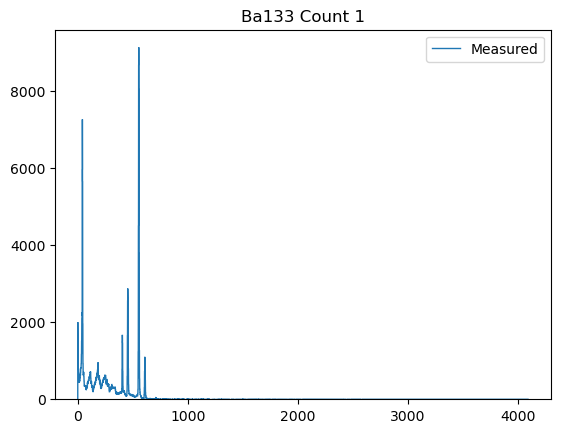

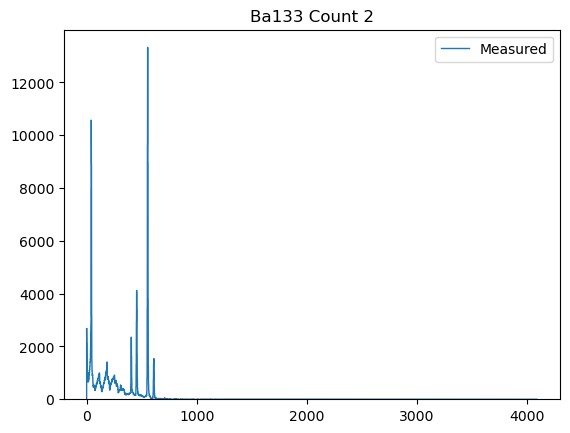

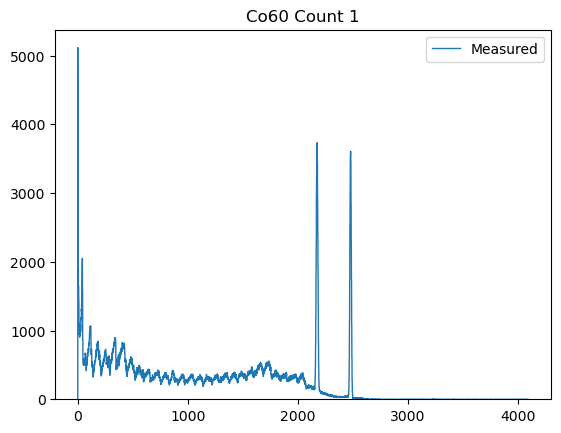

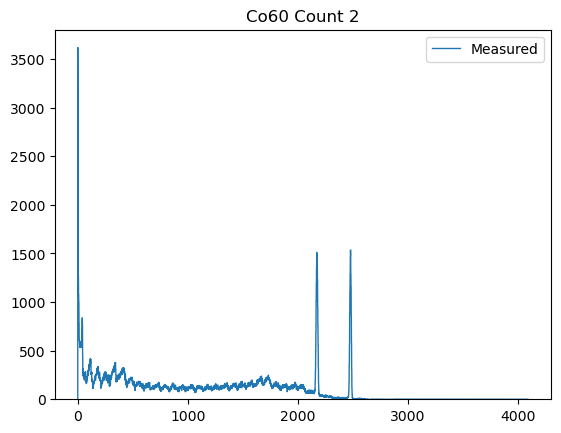

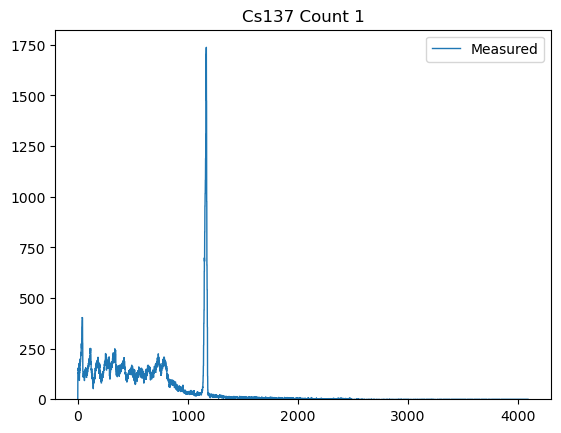

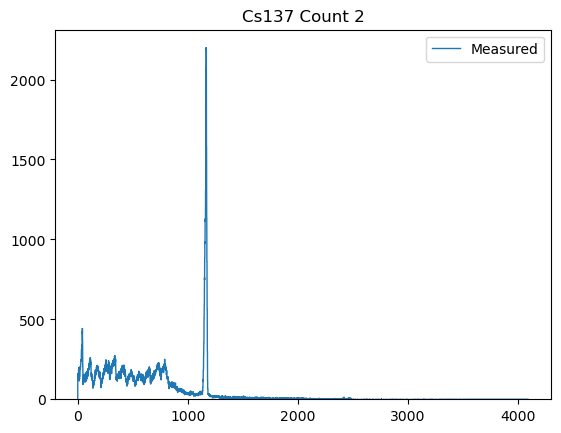

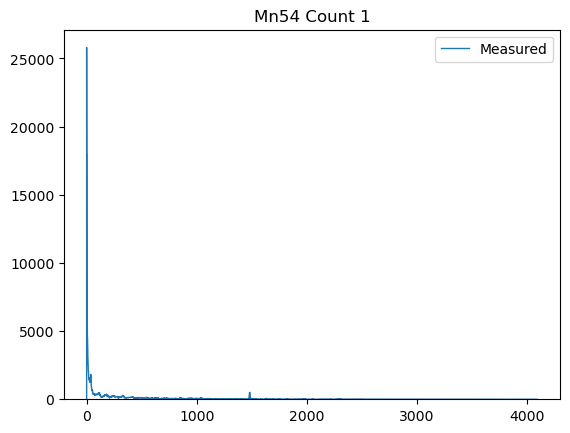

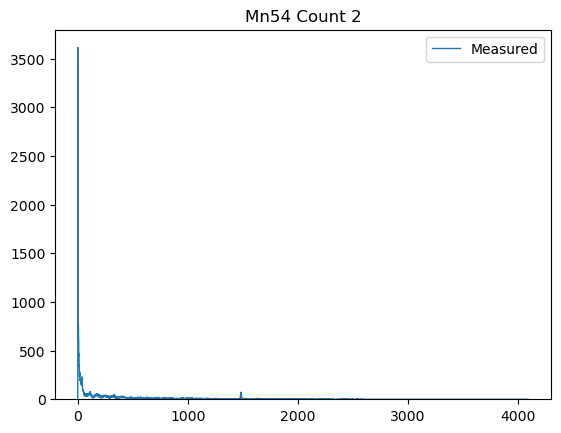

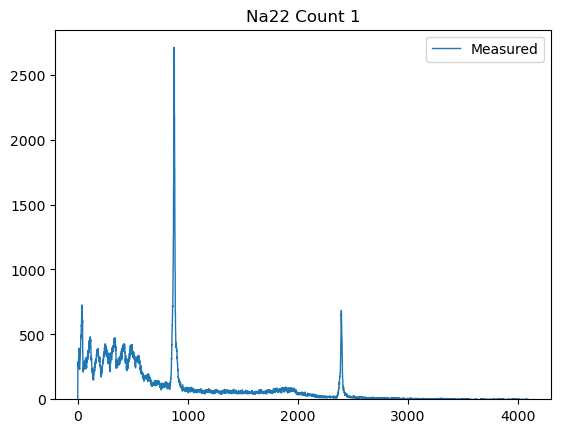

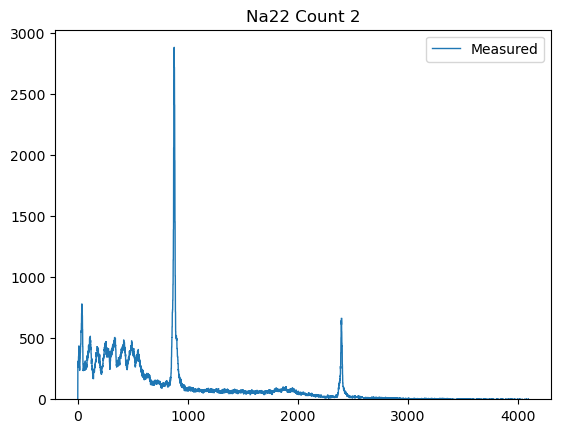

In [12]:
for name, measurement in check_source_measurements.items():
    fig, ax = plt.subplots()
    det = measurement.get_detector(0)
    hist, xvals = det.get_energy_hist()
    ax.stairs(hist, xvals, label=f'Measured')
    ax.legend()
    ax.set_title(name)
    

## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

{'Ba133 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e799820>, 'Ba133 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e799580>, 'Co60 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e799850>, 'Co60 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e799940>, 'Cs137 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e799970>, 'Cs137 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e7999a0>, 'Mn54 Count 1': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e7999d0>, 'Mn54 Count 2': <libra_toolbox.neutron_detection.activation_foils.compass.CheckSourceMeasurement object at 0x18e799a00>, 'Na22 Count 1': <libra_tool

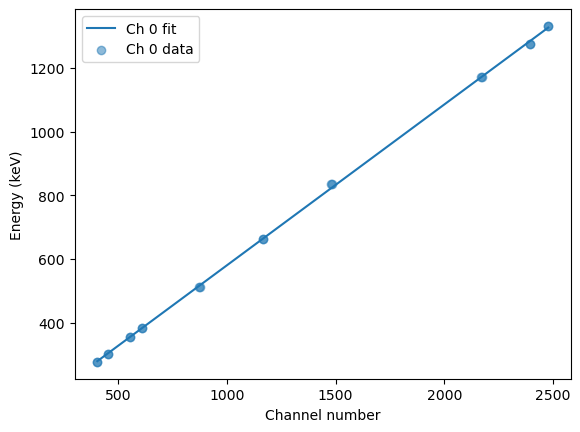

In [5]:
calibration_coeffs = {}
print(check_source_measurements)
channel_nb = check_source_measurements["Ba133 Count 1"].detectors[0].channel_nb
calibration_channels, calibration_energies = compass.get_calibration_data(
    check_source_measurements.values(),
    background_measurement=background_meas,
    channel_nb=channel_nb,
)

coeff = np.polyfit(calibration_channels, calibration_energies, 1)
calibration_coeffs[channel_nb] = coeff

xs = np.linspace(
    calibration_channels[0],
    calibration_channels[-1],
)
plt.plot(
    xs,
    np.polyval(coeff, xs),
    label=f"Ch {channel_nb} fit",
)
plt.scatter(
    calibration_channels,
    calibration_energies,
    label=f"Ch {channel_nb} data",
    alpha=0.5,
)
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [9]:
for name, measurement in check_source_measurements.items():
    for detector in measurement.detectors:
        dead_time_fraction = 1 - detector.live_count_time / detector.real_count_time
        print(f"{name} Ch {detector.channel_nb} \n\t Live time: {detector.live_count_time} s \n\t Real time: {detector.real_count_time} s")
        print(f"\t Dead time fraction: {dead_time_fraction:.2%}")

Ba133 Count 1 Ch 0 
	 Live time: 215.615 s 
	 Real time: 723.787 s
	 Dead time fraction: 70.21%
Ba133 Count 2 Ch 0 
	 Live time: 281.445 s 
	 Real time: 979.895 s
	 Dead time fraction: 71.28%
Co60 Count 1 Ch 0 
	 Live time: 710.572 s 
	 Real time: 3804.486 s
	 Dead time fraction: 81.32%
Co60 Count 2 Ch 0 
	 Live time: 315.347 s 
	 Real time: 1471.362 s
	 Dead time fraction: 78.57%
Cs137 Count 1 Ch 0 
	 Live time: 24.237 s 
	 Real time: 133.073 s
	 Dead time fraction: 81.79%
Cs137 Count 2 Ch 0 
	 Live time: 25.704 s 
	 Real time: 148.404 s
	 Dead time fraction: 82.68%
Mn54 Count 1 Ch 0 
	 Live time: 571.499 s 
	 Real time: 11601.018 s
	 Dead time fraction: 95.07%
Mn54 Count 2 Ch 0 
	 Live time: 82.546 s 
	 Real time: 1644.191 s
	 Dead time fraction: 94.98%
Na22 Count 1 Ch 0 
	 Live time: 30.234 s 
	 Real time: 284.586 s
	 Dead time fraction: 89.38%
Na22 Count 2 Ch 0 
	 Live time: 29.578 s 
	 Real time: 316.485 s
	 Dead time fraction: 90.65%


In [ ]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

In [ ]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

def gauss(x, b, m, *args):
    """Creates a multipeak gaussian with a linear addition of the form:
    m * x + b + Sum_i (A_i * exp(-(x - x_i)**2) / (2 * sigma_i**2)"""

    out = m * x + b
    if np.mod(len(args), 3) == 0:
        for i in range(int(len(args) / 3)):
            out += args[i * 3 + 0] * np.exp(
                -((x - args[i * 3 + 1]) ** 2) / (2 * args[i * 3 + 2] ** 2)
            )
    else:
        raise ValueError("Incorrect number of gaussian arguments given.")
    return out


def fit_peak_gauss(hist, xvals, peak_ergs, search_width=600, threshold_overlap=200, axes=None):

    if len(peak_ergs) > 1:
        if np.max(peak_ergs) - np.min(peak_ergs) > threshold_overlap:
            raise ValueError(
                f"Peak energies {peak_ergs} are too far away from each to be fitted together."
            )
    

    search_start = np.argmin(
        np.abs((peak_ergs[0] - search_width / ( len(peak_ergs))) - xvals)
    )
    search_end = np.argmin(
        np.abs((peak_ergs[-1] + search_width / (len(peak_ergs))) - xvals)
    )

    slope_guess = (hist[search_end] - hist[search_start]) / (
        xvals[search_end] - xvals[search_start]
    )

    # guess_parameters = [0, slope_guess]
    guess_parameters = [0, 0]


    for i in range(len(peak_ergs)):
        # correct peak_ind for bad calibration
        peak, _ = find_peaks(hist[search_start:search_end], height=np.max(hist[search_start:search_end]) * 0.5)
        if len(peak) != 1:
            print(f"Warning: Found {len(peak)} peaks in the search range for peak energy {peak_ergs[i]} keV. Using the first one found.")
        peak_ind = peak[0] + search_start
        old_peak_ind = np.argmin(np.abs((peak_ergs[i]) - xvals))
        print("New peak index:", peak_ind, "Old peak index:", old_peak_ind, "Peak energy:", peak_ergs[i], "Measured Energy:", xvals[peak_ind], "Peak height:", hist[peak_ind])
        # print("Notebook: Peak index:", peak_ind, "Peak energy:", peak_ergs[i], "Peak height:", hist[peak_ind])
        guess_parameters += [
            hist[peak_ind],
            peak_ergs[i],
            search_width / (3 * len(peak_ergs)),
        ]

    if axes is not None:
        # axes.plot(
        #     xvals[search_start:search_end],
        #     gauss(xvals[search_start:search_end], *guess_parameters),
        #     "--",
        #     label="Initial guess",
        # )
        axes.axvspan(
            xvals[search_start],
            xvals[search_end],
            color="red",
            alpha=0.1,
            label="Peak range",
        )
    # print('Notebook: Search start:', search_start, ' Search end:', search_end)
    print("Notebook: Guess parameters:", guess_parameters)

    parameters, covariance = curve_fit(
        gauss,
        xvals[search_start:search_end],
        hist[search_start:search_end],
        p0=guess_parameters,
    )

    return parameters, covariance, search_start, search_end


def get_multipeak_area(
    hist, bins, peak_ergs, search_width=600, threshold_overlap=200, axes=None
):
    # print("search_width:", search_width)
    if len(peak_ergs) > 1:
        if np.max(peak_ergs) - np.min(peak_ergs) > threshold_overlap:
            areas = []
            for p, peak in enumerate(peak_ergs):
                if isinstance(search_width, (np.ndarray, list)):
                    search_w = int(search_width[p])
                    # print("search_width is an array, using value for peak", p, ":", search_w)
                else:
                    # print("search_width is not an array, using single value")
                    search_w = int(search_width)
                # print("peak", peak, "search_w:", search_w)
                area = get_multipeak_area(
                    hist,
                    bins,
                    [peak],
                    search_width=search_w,
                    threshold_overlap=threshold_overlap,
                    axes=axes
                )
                areas += area
            return areas
    if isinstance(search_width, (np.ndarray, list)):
        search_width = int(search_width[0])
        print("search_width is an array, using first value:", search_width)

    # get midpoints of every bin
    xvals = np.diff(bins) / 2 + bins[:-1]
    # print("notebook bins length:", len(bins))
    # print("notebook xvals:", xvals)
    # print("notebook hist[0, -1]: ", hist[0], hist[-1])
    # print("notebook peak_ergs:", peak_ergs)


    parameters, covariance, search_start, search_end = fit_peak_gauss(
        hist, xvals, peak_ergs, search_width=search_width, axes=axes,
    )

    areas = []
    peak_starts = []
    peak_ends = []
    all_peak_params = []
    # print("search width:", search_width)
    # print("threshold overlap:", threshold_overlap)
    # print(axes)
    # peak_amplitudes = []
    for i in range(len(peak_ergs)):
        # peak_amplitudes += [parameters[2 + 3 * i]]
        mean = parameters[2 + 3 * i + 1]
        sigma = np.abs(parameters[2 + 3 * i + 2])
        peak_start = np.argmin(np.abs((mean - 3 * sigma) - xvals))
        peak_end = np.argmin(np.abs((mean + 3 * sigma) - xvals))

        peak_starts += [peak_start]
        peak_ends += [peak_end]

        x_vals = np.linspace(
            xvals[search_start], xvals[search_end], 100
        )

        y_vals = gauss(
            x_vals, parameters[0], parameters[1], *parameters[2 + 3 * i : 2 + 3 * (i + 1)]
        )
        # print(x_vals, y_vals)
        if axes is not None:
            trap_line = parameters[0] + parameters[1] * x_vals
            axes.plot(x_vals, trap_line, '--', label=f"Bg Cutoff for Peak {mean:.0f} keV")
            axes.plot(x_vals, y_vals, '-', label=f"Peak {mean:.0f} keV")

        # Use unimodal gaussian to estimate counts from just one peak
        peak_params = [parameters[0], parameters[1], parameters[2 + 3 * i], mean, sigma]
        all_peak_params += [peak_params]
        gross_area = np.trapezoid(
            gauss(xvals[peak_start:peak_end], *peak_params),
            x=xvals[peak_start:peak_end],
        )

        
        # Cut off trapezoidal area due to compton scattering and noise
        trap_cutoff_area = np.trapezoid(
            parameters[0] + parameters[1] * xvals[peak_start:peak_end],
            x=xvals[peak_start:peak_end],
        )
        area = gross_area - trap_cutoff_area
        areas += [area]

        print(f"NOTE: Peak Energy: {mean:.2f} keV, Gross Area: {gross_area:.2f}, Cutoff Area: {trap_cutoff_area:.2f}, Net Area: {area:.2f}")

    return areas

Expected energy: 276.3989 keV, Found peaks at: [278.75219504] keV with heights: [1611.67702259] counts
Expected energy: 302.8508 keV, Found peaks at: [303.53680846] keV with heights: [2839.60464622] counts
Expected energy: 356.0129 keV, Found peaks at: [354.11765218] keV with heights: [9086.19518642] counts
Expected energy: 383.8485 keV, Found peaks at: [381.93711623] keV with heights: [1067.77841238] counts
Notebook: uncalibrated measured energies: [np.int64(405), np.int64(454), np.int64(554), np.int64(610)]
Notebook: calibration coefficients: [ 0.50580844 73.89977797]
Cell: calibrated measured energies: [278.75219504 303.53680846 354.11765218 382.44292467]
Notebook: calibrated measured energies: [278.75219504 303.53680846 354.11765218 382.44292467]
New peak index: 405 Old peak index: 405 Peak energy: 278.7521950392311 Measured Energy: 279.00509925783916 Peak height: 1611.6770225864796
Notebook: Guess parameters: [0, 0, np.float64(1611.6770225864796), np.float64(278.7521950392311), 6.

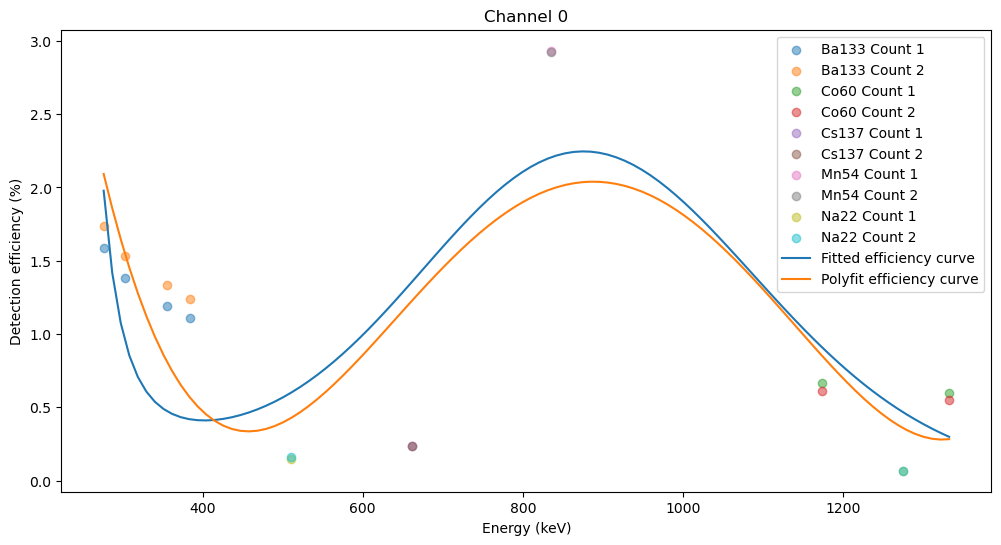

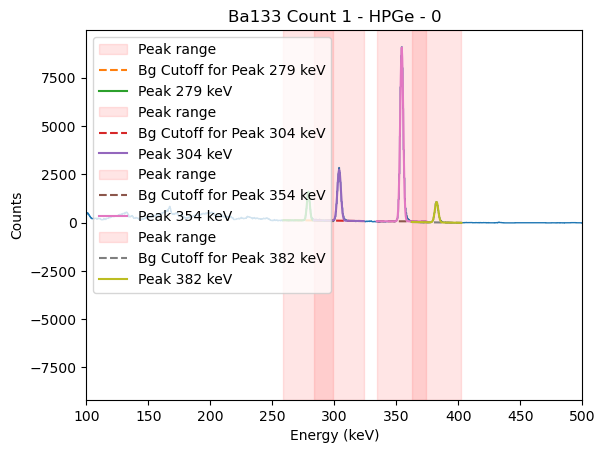

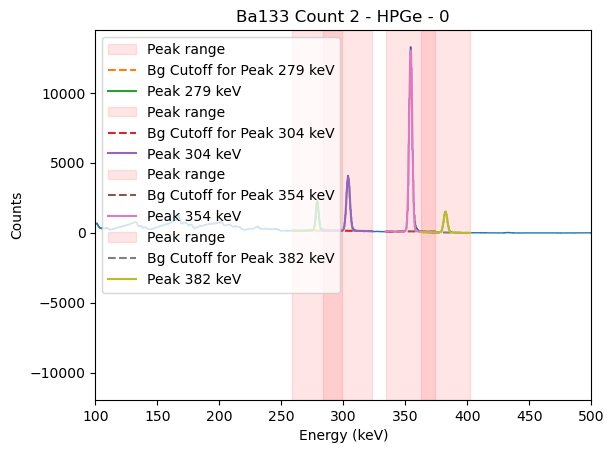

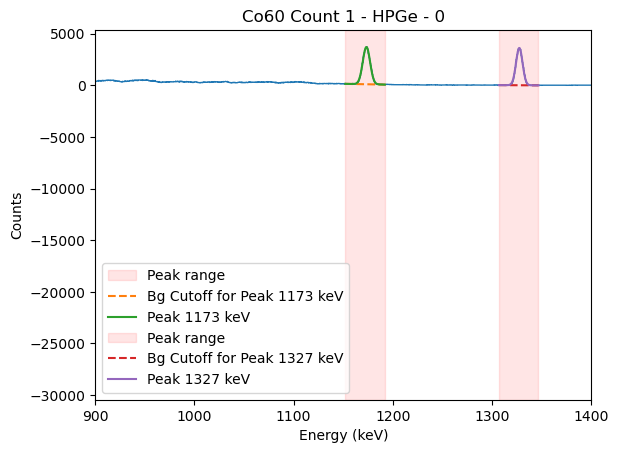

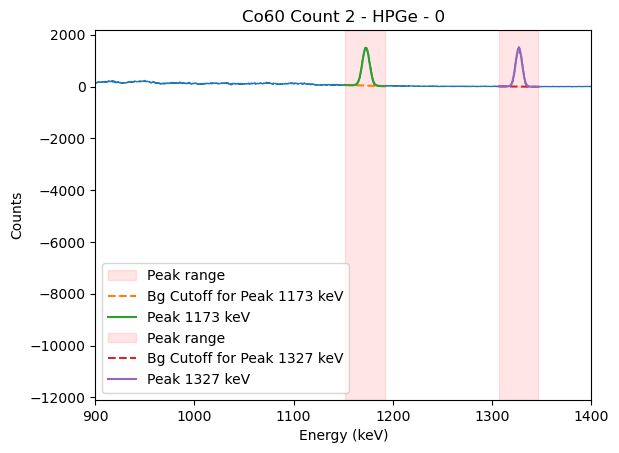

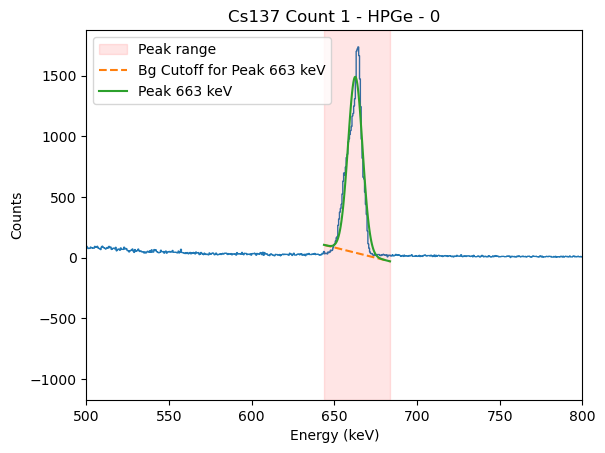

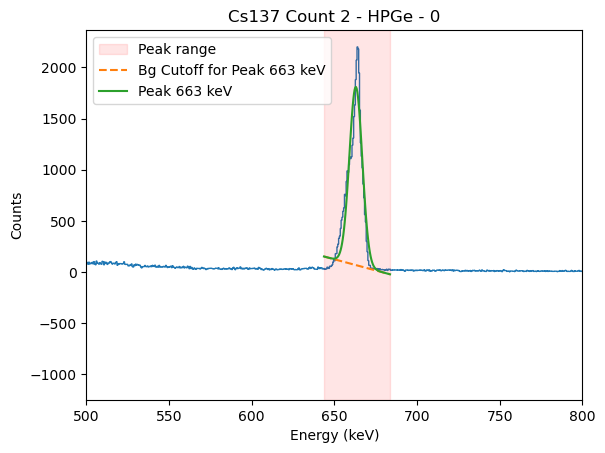

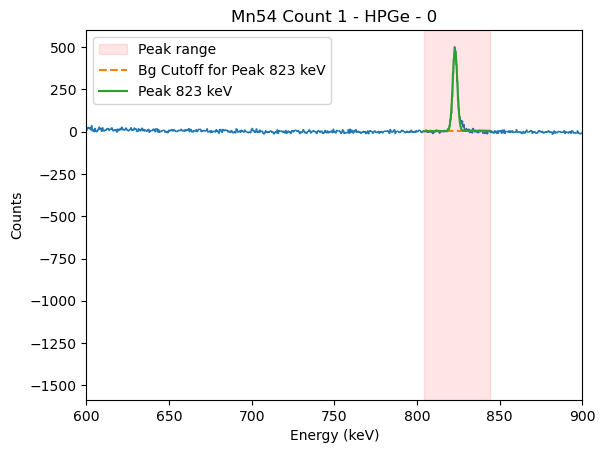

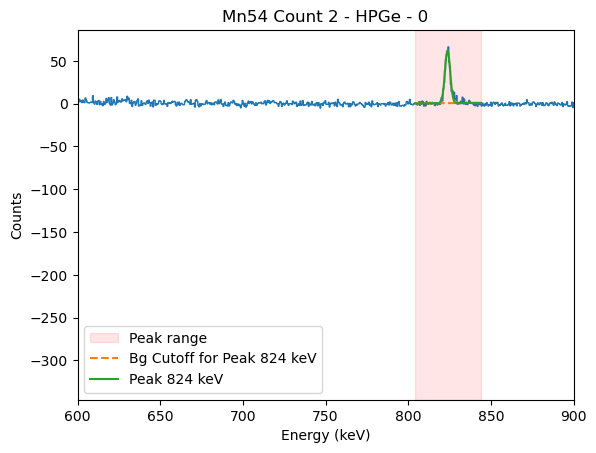

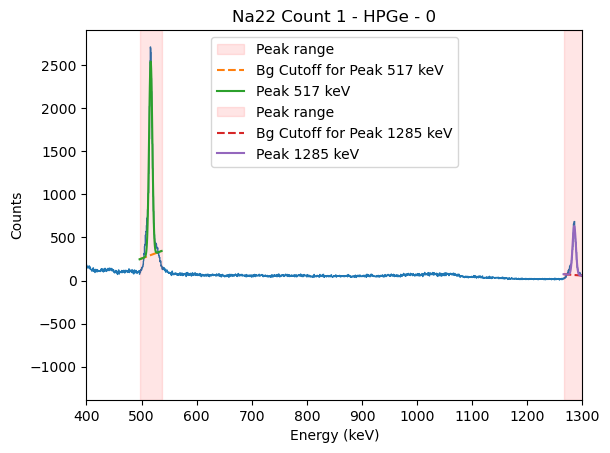

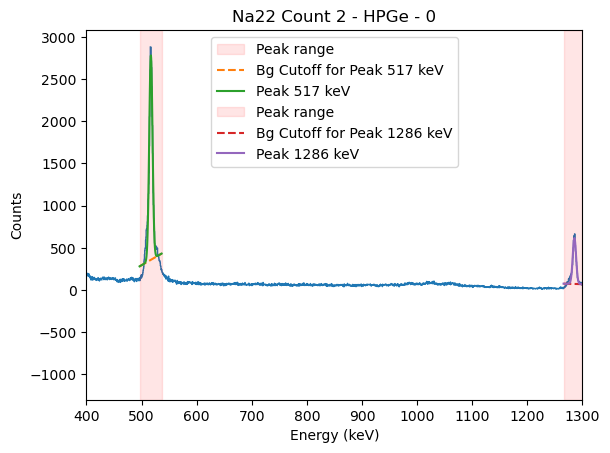

In [ ]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements.values())[0]

# search_widths = np.arange(20, 50, 2)
# for search_width in search_widths:
search_width = 20
threshold_overlap = 10
for detector in measurement.detectors:
    channels.append(detector.channel_nb)

xlim_dict = {
    'Ba133': [100, 500],
    'Co60': [900, 1400],
    'Cs137': [500, 800],
    'Mn54': [600, 900],
    'Na22': [400, 1300],
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

background_detector = background_meas.get_detector(channel_nb)
energies = []
efficiencies = []
for name, measurement in check_source_measurements.items():
    check_source_detector = measurement.get_detector(channel_nb)
    hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector, bins=None)
    calibrated_bin_edges = np.polyval(calibration_coeffs[channel_nb], bin_edges)

    # plot the histogram
    fig2,ax2 = plt.subplots()
    ax2.stairs(hist, calibrated_bin_edges)
    # ax2.set_xlim(left=0, right=500)

    # See how well calibrated peaks match expected energies
    expected_energies = measurement.check_source.nuclide.energy
    for energy in expected_energies:
        lower_ind = np.argmin(np.abs((energy - search_width) - calibrated_bin_edges))
        upper_ind = np.argmin(np.abs((energy + search_width) - calibrated_bin_edges))
        hist_search = hist[lower_ind:upper_ind]

        peaks, peak_params = find_peaks(hist_search, height=np.max(hist_search) * 0.5)
        print(f"Expected energy: {energy} keV, Found peaks at: {calibrated_bin_edges[lower_ind:upper_ind][peaks]} keV with heights: {peak_params['peak_heights']} counts")

    # print('notebook search_width:', search_width, ' threshold_overlap:', threshold_overlap)
    print("Notebook: uncalibrated measured energies:", measurement.check_source.nuclide._uncalibrated_measured_energies[channel_nb])
    print("Notebook: calibration coefficients:", calibration_coeffs[channel_nb])
    uncalibrated = np.array(
                measurement.check_source.nuclide._uncalibrated_measured_energies.get(channel_nb, []),
                dtype=float
            )
    calibrated_ergs = np.polyval(calibration_coeffs[channel_nb], uncalibrated)
    print('Cell: calibrated measured energies:', calibrated_ergs)
    print("Notebook: calibrated measured energies:", measurement.check_source.nuclide.calibrated_measured_energies(channel_nb, 
                                                                                                                   calibration_coeffs[channel_nb]))
    areas = get_multipeak_area(
        hist, 
        calibrated_bin_edges, 
        measurement.check_source.nuclide.calibrated_measured_energies(channel_nb, 
                                                                      calibration_coeffs[channel_nb]),
        search_width=search_width,
        threshold_overlap=threshold_overlap, 
        axes=ax2
    )

    print("Notebook Areas: ", areas)
    print("")
    ax2.set_xlabel("Energy (keV)")
    ax2.set_ylabel("Counts")
    ax2.set_title(f"{measurement.name} - {measurement.detector_type} - {channel_nb}")
    ax2.legend()
    nuclide = name.split()[0]
    if nuclide in xlim_dict:
        ax2.set_xlim(left=xlim_dict[nuclide][0], right=xlim_dict[nuclide][1])
    else:
        ax2.set_xlim(left=0, right=1500)
    
    efficiency = measurement.compute_detection_efficiency(
        background_measurement=background_meas,
        calibration_coeffs=calibration_coeffs[channel_nb],
        channel_nb=channel_nb,
        search_width=search_width,
        threshold_overlap=threshold_overlap,
        # summing_method='sum_gaussian',
        summing_method='sum_histogram'
    )
    print("\n" + "=" * 40)

    energies += measurement.check_source.nuclide.energy
    efficiencies += list(efficiency)
    ax.scatter(
        measurement.check_source.nuclide.energy,
        efficiency * 100,
        label=name,
        alpha=0.5
    )

# Sort energies and efficiencies for fitting
sorted_indices = np.argsort(energies)
energies = np.array(energies)[sorted_indices]
efficiencies = np.array(efficiencies)[sorted_indices]
print(f"Ch {channel_nb} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

# Fit the efficiency curve
popt, pcov = curve_fit(
    eff_curve_func,
    energies,
    efficiencies,
    p0=[-1, 1, 0, 0],
)

poly_coeff = np.polyfit(energies, efficiencies, 4)
efficiency_coeffs[channel_nb] = poly_coeff
xs = np.linspace(
    energies[0],
    energies[-1],
    100,
)
ax.plot(
    xs,
    eff_curve_func(xs, *popt) * 100,
    label="Fitted efficiency curve",
)

ax.plot(
    xs,
    np.polyval(poly_coeff, xs) * 100,
    label="Polyfit efficiency curve",
)
ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Detection efficiency (%)")
ax.set_title(f"Channel {channel_nb}")
ax.legend()
# plt.ylim(bottom=0)
print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [ ]:
all_neutron_rates = []
all_neutron_rates_err = []

In [ ]:
from process_foil_data import irradiations, time_generator_off

### Niobium Packet #3 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the various measurements of the Niobium Packet #3 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
print(foil_measurements["Nb Packet #6"])

In [ ]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Nb Packet #6"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=15)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the various measurements of the Zirconium Packet #1 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
foil_name = "Zr Packet #1"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=15)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [ ]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

In [ ]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")